In [1]:
# set up some environmental dependencies
import time, sys, os
import h5py
import numpy as np
from astropy.table import Table
import scipy
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table
import astropy.cosmology.units as cu
import astropy.units as u
from matplotlib.pyplot import *
import seaborn as sns
import numpy as np, matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from astropy.io import ascii
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
import matplotlib
from astropy.table import Table
import warnings
from scipy.optimize import curve_fit
warnings.filterwarnings("ignore")

# standard imports for my work
from bpt_utils import *
from read_transients_data import *
from correct_redshift_evolution import *
from generate_bkg_galaxies import *
from helper_functions import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'
sns.set_context('talk') 
sns.set(font_scale=1.2)
sns.set_palette('colorblind')
sns.set_style('ticks')
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Verdana', 'Lucida Grande', 'DejaVu Sans']

cmap = matplotlib.cm.get_cmap('magma_r')
colors = ["white", "white", "white"]+[cmap(i/100) for i in range(100)]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
                                                           colors)


### CCSNe and FRBs distribution at low redshifts

In [2]:
CCSN_df = read_CCSNe_hosts_data()
CCSN_df = CCSN_df[CCSN_df["z"]<=0.2].reset_index()
CCSN_df.head(2)


,index,logM,logM_errl,logM_erru,logSFR,logSFR_errl,logSFR_erru,SN_type,z,filter,rmag,ID
0,0,9.17,0.17,0.12,-0.82,0.71,1.27,SN II,0.064,r,18.47,PTF09axi
1,1,6.51,0.43,0.66,-0.91,1.15,0.92,SN II,0.102,r,24.04,PTF09be


In [3]:
frb_df = read_frbs_hosts_data()
frb_df = frb_df[frb_df["z"]<=0.2].reset_index()
frb_df = frb_df.drop(labels=['index'], axis=1)
frb_df.head(2)


,logM,logM_errl,logM_erru,logSFR,logSFR_errl,logSFR_erru,z
0,10.100713,0.004180,0.002193,-0.372874,0.021965,0.022199,0.0112
1,10.399136,0.002144,0.002161,-0.395910,0.027929,0.019919,0.0368


In [4]:
Nsamp = 1000

frb_logM_samples_corr, frb_logSFR_samples_corr = [], []
for i in range(len(frb_df.logM)):
    frb_logM_samples_corr.append(generate_samples(frb_df["logM"][i], frb_df["logM_errl"][i], frb_df["logM_erru"][i], Nsamp))
    frb_logSFR_samples_corr.append(generate_samples(frb_df["logSFR"][i], frb_df["logSFR_errl"][i], frb_df["logSFR_erru"][i], Nsamp))
frb_logM_samples_corr, frb_logSFR_samples_corr = np.array(frb_logM_samples_corr), np.array(frb_logSFR_samples_corr)

CCSN_logM_samples_corr, CCSN_logSFR_samples_corr = generate_z_corr_samples(CCSN_df)


100%|████████████████████████████████████████████████████████████| 293/293 [00:06<00:00, 48.49it/s]


In [5]:
# distributions of CCSNe and FRBs

def get_hist_outs(logMsamples):
    """
    Compute histograms of logM samples.

    Parameters:
    - logMsamples: 2D array of logM samples

    Returns:
    - outs_logM: List of arrays containing density histograms for each column of logMsamples
    """
    bins_logM = np.arange(7, 12, 0.6)
    outs_logM = []
    for i in tqdm(range(np.shape(logMsamples)[1])):
        out = plt.hist(logMsamples[:, i],
                       bins=bins_logM, alpha=0,
                       histtype="step", color="blue", lw=1,
                       density=True)
        outs_logM.append(out[0])
    plt.close()
    return outs_logM

CCSN_outs_logM = get_hist_outs(CCSN_logM_samples_corr)
frb_outs_logM = get_hist_outs(frb_logM_samples_corr)


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 886.68it/s]


### Background galaxy population distribution weighted by SFR

In [6]:
# Grid parameters for galaxy density function in logMass - logSFR - redshift space
nlogm, nsfr, dz = 40, 40, 0.001
mmin, mmax = 5, 12
sfrmin, sfrmax = -5, 3

redshifts, bkg_grid_below_mcomp = generate_bkg_grid_below_mcomp()
kernel = Gaussian1DKernel(stddev=2) 
prob_smooth = np.zeros(np.shape(bkg_grid_below_mcomp))
for i in range(nlogm):
    for j in range(nsfr):
        prob_smooth[:][i][j] = convolve(bkg_grid_below_mcomp[:][i][j],kernel,boundary='extend',preserve_nan=True)
bkg_grid_below_mcomp = prob_smooth


100%|██████████████████████████████████████████████████████████████| 50/50 [14:30<00:00, 17.41s/it]


In [7]:
# Generate 1000 realizations of background galaxies with 10000 galaxies each 
# in the z<=0.2 redshift bin

f_r = 3e10*1400e-8/(6215e-8**2)
F_r = 10**((23.5)/-2.5)*3631*1e-23*f_r #erg/s/cm2
Nbkg = 1000
Nsamp = 10000

bkg_redshift_z1, logmstar_bkgs_z1, logsfr_bkgs_z1 = [], [], []
logmstar_bkgs_z1_wo_opt_cut, logsfr_bkgs_z1_wo_opt_cut = [], []
for j in tqdm(range(Nbkg)):
    ml_random = np.random.normal(0, 0.2)
    z_random = np.random.uniform(0, 0.2)
    logmstar_bkg, logsfr_bkg = generate_bkg_z(z_random, Nsamp, redshifts, bkg_grid_below_mcomp)
    mmin_ = ml_random+np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z_random).to(u.cm).value**2))/4e33)
    mask = np.array(logmstar_bkg)>mmin_ # apply the optical observation bias
    bkg_redshift_z1.append(z_random)
    logmstar_bkgs_z1.append(np.array(logmstar_bkg)[mask])
    logsfr_bkgs_z1.append(np.array(logsfr_bkg)[mask])
    logmstar_bkgs_z1_wo_opt_cut.append(np.array(logmstar_bkg))
    logsfr_bkgs_z1_wo_opt_cut.append(np.array(logsfr_bkg))


100%|██████████████████████████████████████████████████████████| 1000/1000 [09:28<00:00,  1.76it/s]


In [8]:
# Computing histograms of mass and SFR-weighted background galaxy distributions
bins_logM = np.arange(7, 12, 0.6)

Nbkg, Nsamp = 100, 1000
bkg_s_z1, out_bkg_s_z1 = [], []
bkg_m_z1, out_bkg_m_z1 = [], []

from scipy import stats
for j in tqdm(range(Nbkg)):
    logmsamples = np.random.choice(logmstar_bkgs_z1[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logsfr_bkgs_z1[j])/sum(10**np.array(logsfr_bkgs_z1[j])))
    bkg_s_z1.append(logmsamples)
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0,
                   histtype="step", color="blue", lw=1, density=True)
    out_bkg_s_z1.append(out[0])

    logmsamples = np.random.choice(logmstar_bkgs_z1[j], size=Nsamp, replace=True, 
                                   p=10**np.array(logmstar_bkgs_z1[j])/sum(10**np.array(logmstar_bkgs_z1[j])))
    bkg_m_z1.append(logmsamples)
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0,
                   histtype="step", color="blue", lw=1, density=True)
    out_bkg_m_z1.append(out[0])
plt.close()

100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 302.25it/s]


### Weight background galaxy population distribution by SFR and metallicity

In [9]:
bins_logM_ = []
for i in range(len(bins_logM)-1):
    bins_logM_.append(bins_logM[i]), bins_logM_.append(bins_logM[i+1])
    
initial_guess = [1, 10, 1, 1]

def gaussian(x, A, mu, sigma1, sigma2):
    """
    Compute a piecewise Gaussian function.

    Parameters:
    - x: Input array
    - A: Amplitude of the Gaussian
    - mu: Mean of the Gaussian
    - sigma1: Standard deviation for x <= mu
    - sigma2: Standard deviation for x > mu

    Returns:
    - Array of Gaussian values evaluated at x
    """
    return A * np.exp(-0.5 * ((x - mu) ** 2 / sigma1 ** 2) * (x <= mu) - 0.5 * ((x - mu) ** 2 / sigma2 ** 2) * (x > mu))


def sigmoid(x, mean, beta=1):
    """
    Compute the sigmoid function.

    Parameters:
    - x: Input array
    - mean: Mean or midpoint of the sigmoid
    - beta: Slope parameter (default is 1)

    Returns:
    - Array of sigmoid values evaluated at x
    """
    return 1 / (1 + np.exp(-beta*(x-mean)))


# Using Schulze et al. Metallicity Bias
Ngrid = 50
logm_met_cutoff_grid = np.linspace(8, 10, Ngrid)
beta_grid = 10**np.linspace(0, 8, Ngrid)
chi2_grid = np.zeros((Ngrid, Ngrid))
logm = np.linspace(7, 12, 10000)

# Gaussian fits to FRB distributions for comparison
frb_quant16, frb_quant50, frb_quant84 = return_quants(frb_outs_logM, 1)
params, _ = curve_fit(gaussian, bins_logM_, frb_quant50, p0=initial_guess)
gaussian_fit_to_frb = gaussian(logm, *params)
params, _ = curve_fit(gaussian, bins_logM_, (np.array(frb_quant50)+np.array(frb_quant16)), p0=initial_guess)
gaussian_fit_to_frb_errl = gaussian(logm, *params)-gaussian_fit_to_frb
params, _ = curve_fit(gaussian, bins_logM_, (np.array(frb_quant50)+np.array(frb_quant84)), p0=initial_guess)
gaussian_fit_to_frb_erru = gaussian(logm, *params)-gaussian_fit_to_frb
gaussian_fit_to_frb_err = np.maximum(np.abs(gaussian_fit_to_frb_errl), gaussian_fit_to_frb_erru)

plt.figure()
for i in tqdm(range(Ngrid)):
    for k in range(Ngrid):
        logm_zlim = logm_met_cutoff_grid[i]
        beta = beta_grid[k]

        # Generate metallicity-weighted background distribution
        Nbkg, Nsamp = 100, 1000
        out_bkg_s_z1_temp = []
        for j in (range(Nbkg)):
            prob = (10**np.array(logsfr_bkgs_z1[j])) * (sigmoid(logmstar_bkgs_z1[j], logm_zlim, beta=beta))
            prob /= sum(prob)
            logmsamples = np.random.choice(logmstar_bkgs_z1[j], size=Nsamp, replace=True, p=prob)
            out = plt.hist(logmsamples, bins=bins_logM, alpha=0,
                           histtype="step", color="blue", lw=1, density=True)
            out_bkg_s_z1_temp.append(out[0])
        plt.close()


        # Compare FRBs distribution with metallicity-weighted background distribution
        quant16, quant50, quant84 = return_quants(out_bkg_s_z1_temp, 1)
        params, _ = curve_fit(gaussian, bins_logM_, quant50, p0=initial_guess)
        gaussian_fit_to_bkg = gaussian(logm, *params)
        params, _ = curve_fit(gaussian, bins_logM_, (np.array(quant50)+np.array(quant16)), p0=initial_guess)
        gaussian_fit_to_bkg_errl = gaussian(logm, *params)-gaussian_fit_to_bkg
        params, _ = curve_fit(gaussian, bins_logM_, (np.array(quant50)+np.array(quant84)), p0=initial_guess)
        gaussian_fit_to_bkg_erru = gaussian(logm, *params)-gaussian_fit_to_bkg
        gaussian_fit_to_bkg_err = (np.maximum(np.abs(gaussian_fit_to_bkg_errl), gaussian_fit_to_bkg_erru))/np.sqrt(Nbkg)

        combined_error = np.sqrt(gaussian_fit_to_frb_err**2 + gaussian_fit_to_bkg_err**2)
        chi2_grid[i][k] = np.sum(((gaussian_fit_to_bkg-gaussian_fit_to_frb)**2)/((combined_error**2)))/len(logm)


100%|██████████████████████████████████████████████████████████████| 50/50 [06:45<00:00,  8.12s/it]


In [10]:
# Printing the optimal M_c and beta with minimum abs(reduced chi^2 - 1)
chi2_grid_metric = np.abs(chi2_grid-1)
logm_zlim_best = logm_met_cutoff_grid[np.where(chi2_grid_metric==np.min(chi2_grid_metric))[0][0]]
beta_best = beta_grid[np.where(chi2_grid_metric==np.min(chi2_grid_metric))[1][0]]

logm_zlim_best, beta_best


(8.857142857142858, 115139.53993264458)

In [11]:
# Computing metallicity corresponding to M_c using Gallazzi et al. mass-metallicity correlation
massmet = np.loadtxt('galaxies_data/gallazzi_05_massmet.txt')

print("metallicity")
z_1 = np.interp(logm_zlim_best, massmet[:, 0], massmet[:, 2])
z_2 = np.interp(logm_zlim_best, massmet[:, 0], massmet[:, 1])
z_3 = np.interp(logm_zlim_best, massmet[:, 0], massmet[:, 3])
z_2, z_1-z_2, z_3-z_2


metallicity


(-0.6, -0.5100000000000001, 0.6)

In [12]:
# Generate metallicity-weighted background distribution
Nbkg, Nsamp = 100, 1000
out_bkg_s_z1_z = []
for j in (range(Nbkg)):
    prob = (10**np.array(logsfr_bkgs_z1[j])) * (sigmoid(logmstar_bkgs_z1[j], logm_zlim_best, beta=beta_best))
    prob /= sum(prob)
    logmsamples = np.random.choice(logmstar_bkgs_z1[j], size=Nsamp, replace=True, p=prob)
    out = plt.hist(logmsamples, bins=bins_logM, alpha=0,
                   histtype="step", color="blue", lw=1, density=True)
    out_bkg_s_z1_z.append(out[0])
plt.close()


In [13]:
# Reading in DSA, Gordon et al. and Bhardwaj et al. FRBs
dsa_radio_sheet = pd.read_excel('frbs_data/DSA110-FRBs.xlsx', sheet_name='frb_params', engine='openpyxl', keep_default_na=False, na_values='')
dsa_radio_sheet = dsa_radio_sheet.drop(0)

dsa_frbs = read_dsa_data()
askap_frbs = read_askap_frbs()
chime_frbs = read_chime_data()

Text(-0.18, 1.15, 'b')

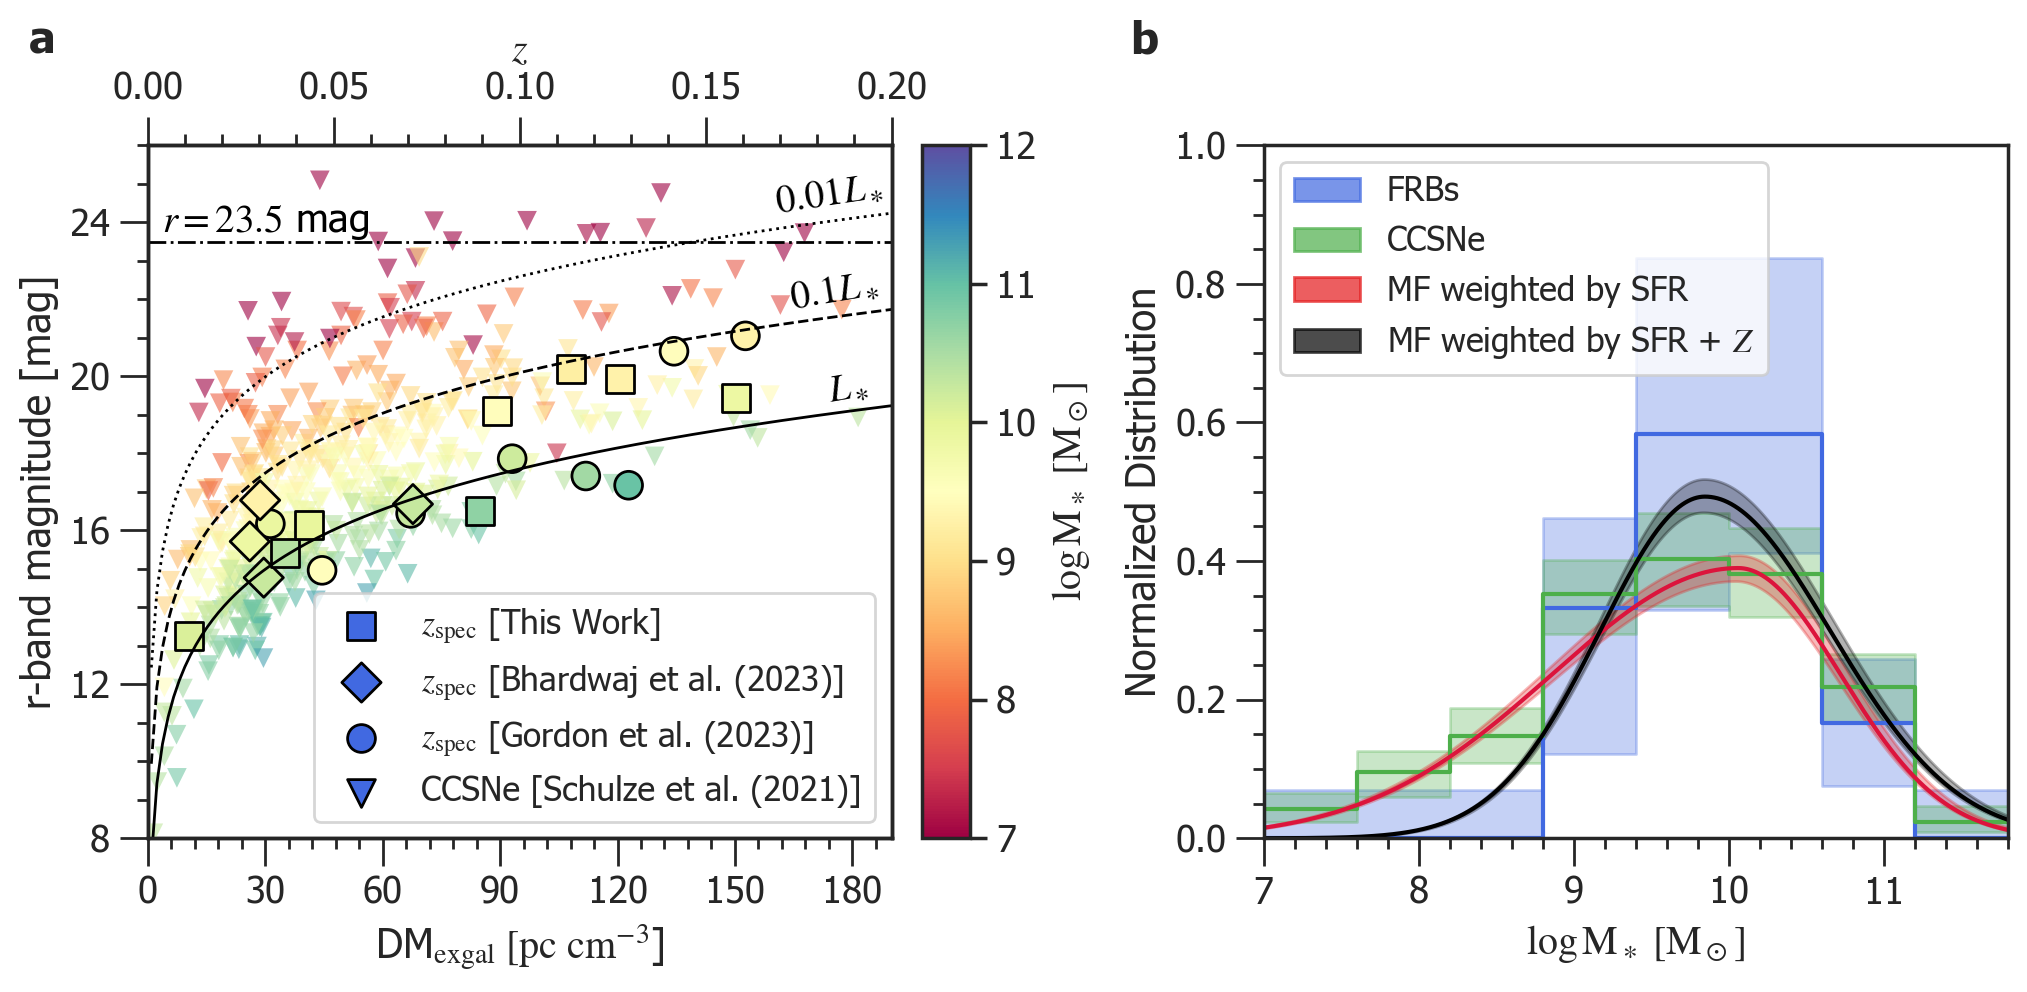

In [14]:
bins_logM_ = []
for i in range(len(bins_logM)-1):
    bins_logM_.append(bins_logM[i]), bins_logM_.append(bins_logM[i+1])

logm = np.linspace(7, 12, 10000)
poiss_zero_errs = np.array([0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0,
                            0.0, 0.0, 0.0, 0.07  , 0.07  ]) # poisson errors on bins with zero counts

fig, (ax1, axes) = plt.subplots(1, 2, figsize=(12, 4.5))
fig.subplots_adjust(wspace=0.5)

axes.tick_params(axis='x')
axes.tick_params(axis='y')

quant16, quant50, quant84 = return_quants(frb_outs_logM, 1)
_ = axes.plot(bins_logM_, np.array(quant50),
              alpha=1, color="royalblue", lw=1.5)
axes.fill_between(bins_logM_, 
                  np.array(quant50)+np.array(quant16)-(np.sqrt(np.array(quant50)/(np.shape(frb_logM_samples_corr)[0])))-poiss_zero_errs, 
                  np.array(quant50)+np.array(quant84)+(np.sqrt(np.array(quant50)/(np.shape(frb_logM_samples_corr)[0])))+poiss_zero_errs, 
                  color="royalblue", alpha=0.3)
axes.fill_between([], [], [], 
                color="royalblue", alpha=0.7, label="FRBs")

quant16, quant50, quant84 = return_quants(CCSN_outs_logM, 1)
_ = axes.plot(bins_logM_, np.array(quant50),
              alpha=1, color="#4daf4a", lw=1.5)
axes.fill_between(bins_logM_, 
                  np.array(quant50)+np.array(quant16)-(np.sqrt(np.array(quant50)/(np.shape(CCSN_logM_samples_corr)[0]))), 
                  np.array(quant50)+np.array(quant84)+(np.sqrt(np.array(quant50)/(np.shape(CCSN_logM_samples_corr)[0]))), 
                  color="#4daf4a", alpha=0.3)
axes.fill_between([], [], [], 
                color="#4daf4a", alpha=0.7, label="CCSNe")

quant16, quant50, quant84 = return_quants(out_bkg_s_z1, 1)
params, _ = curve_fit(gaussian, bins_logM_, quant50, p0=initial_guess)
axes.plot(logm, gaussian(logm, *params), color='crimson', lw=1.5)
params1, _ = curve_fit(gaussian, bins_logM_, (np.array(quant50)+np.array(quant16)/np.sqrt(100)), p0=initial_guess)
params2, _ = curve_fit(gaussian, bins_logM_, (np.array(quant50)+np.array(quant84)/np.sqrt(100)), p0=initial_guess)
axes.fill_between(logm, gaussian(logm, *params1), gaussian(logm, *params2),
                  color="#e41a1c", alpha=0.3)
axes.fill_between([], [], [],
                  color="#e41a1c", alpha=0.7, label="MF weighted by SFR")

quant16, quant50, quant84 = return_quants(out_bkg_s_z1_z, 1)
params, _ = curve_fit(gaussian, bins_logM_, quant50, p0=initial_guess)
axes.plot(logm, gaussian(logm, *params), color='black', lw=1.5)
params1, _ = curve_fit(gaussian, bins_logM_, (np.array(quant50)+np.array(quant16)/np.sqrt(100)), p0=initial_guess)
params2, _ = curve_fit(gaussian, bins_logM_, (np.array(quant50)+np.array(quant84)/np.sqrt(100)), p0=initial_guess)
axes.fill_between(logm, gaussian(logm, *params1), gaussian(logm, *params2),
                  color="black", alpha=0.3)
axes.fill_between([], [], [],
                  color="black", alpha=0.7, label=r"MF weighted by SFR + $Z$")

axes.set_xlim(7, 11.8)
axes.set_ylim(0, 1)
axes.set_xlabel(r"$\log{{\mathrm{M}}_\ast}~[{\mathrm{M}}_\odot]$")
axes.set_ylabel("Normalized Distribution")

axes.set_xticks(np.arange(7, 11.8, 1))                                                                                                                                                                                                                              
axes.set_yticks(np.arange(0, 1, 0.2))                                                                                                                                                                                                                                  
axes.xaxis.set_major_locator(MultipleLocator(1)) 
axes.xaxis.set_minor_locator(MultipleLocator(0.2))                                                                                                                                                                                                                         
axes.yaxis.set_major_locator(MultipleLocator(0.2))                                                                                                                                                                                                                     
axes.yaxis.set_minor_locator(MultipleLocator(0.05)) 
axes.tick_params(direction='out', length=6, width=1, top=False, right=False)
axes.tick_params(which='both', width=1)
axes.tick_params(which='major', length=10)
axes.tick_params(which='minor', length=4)
axes.legend(loc="upper left", fontsize=12, ncol=1)



f_r = 3e10/6215e-8
ax1.set_xlim(0, 190)
ax1.set_yticks(np.arange(14.5, 26, 4))                                                                                                                                                                                                                              
ax1.set_xticks(np.arange(0, 190, 30))
ax1.xaxis.set_major_locator(MultipleLocator(30)) 
ax1.xaxis.set_minor_locator(MultipleLocator(6))                                                                                                                                                                                                                         
ax1.yaxis.set_major_locator(MultipleLocator(4))                                                                                                                                                                                                                     
ax1.yaxis.set_minor_locator(MultipleLocator(1)) 
ax1.tick_params(direction='out', length=6, width=1, top=False, right=False)
ax1.tick_params(which='both', width=1)
ax1.tick_params(which='major', length=10)
ax1.tick_params(which='minor', length=4)
locs = ax1.get_xticks()
ax2 = ax1.twiny()

lsun = 3.846e33 # erg/s
lstar = 1.4e10*lsun
r_freq = 3e10/481e-7 # Hz
z_bins = np.linspace(1e-3, 1.5, 1000)
dist_bins = cosmo.luminosity_distance(z_bins).to(u.cm).value

l = lstar
flux_bins = l/(4*np.pi*(dist_bins**2)) # erg/s/cm2
flux_nu_bins = flux_bins/r_freq
mags = -2.5*np.log10(flux_nu_bins*1e23/3631)
ax2.plot(z_bins, mags, color="black", ls="solid", lw=1)

l = 0.1*lstar
flux_bins = l/(4*np.pi*(dist_bins**2)) # erg/s/cm2
flux_nu_bins = flux_bins/r_freq
mags = -2.5*np.log10(flux_nu_bins*1e23/3631)
ax2.plot(z_bins, mags, color="black", ls="--", lw=1)

l = 0.01*lstar
flux_bins = l/(4*np.pi*(dist_bins**2)) # erg/s/cm2
flux_nu_bins = flux_bins/r_freq
mags = -2.5*np.log10(flux_nu_bins*1e23/3631)
ax2.plot(z_bins, mags, color="black", ls="dotted", lw=1)

CCSN_df_all = read_CCSNe_hosts_data("all")
im = ax2.scatter(CCSN_df_all["z"], CCSN_df_all["rmag"], c = CCSN_df_all["logM"], 
                 cmap="Spectral", marker="v", s=50, edgecolors='None', alpha=0.6)
im.set_clim(7, 12)

im = ax2.scatter(askap_frbs["z"], askap_frbs["rmag"], c = askap_frbs["logMstar"], cmap="Spectral",
                        marker="o", s=100, edgecolors='black', alpha=1)
im.set_clim(7, 12)

im = ax2.scatter(chime_frbs["z"], chime_frbs["rmag"], c = chime_frbs["logMstar"], cmap="Spectral",
                        marker="D", s=100, edgecolors='black', alpha=1)
im.set_clim(7, 12)


for i in range(len(dsa_frbs)):
    dsa_frbs = read_dsa_data().reset_index()
    frb_name = dsa_frbs["frb_name"][i]
    df1 = dsa_frbs[dsa_frbs["frb_name"]==frb_name].reset_index()
    df2 = dsa_radio_sheet[dsa_radio_sheet["Nickname"]==frb_name].reset_index()

    if dsa_frbs["sed_done?"][i] == "Y" and dsa_frbs["sample"][i] == "Gold":
        ra = float(df1["host_loc (deg, deg)"][0].split(", ")[0])
        dec = float(df1["host_loc (deg, deg)"][0].split(", ")[1])
        host_pos = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')
        from dustmaps.sfd import SFDQuery
        from extinction import fitzpatrick99
        sfd = SFDQuery()
        EBV = sfd(host_pos)
        wav = np.array([6215.0])
        corr = 0 # - EBV * fitzpatrick99(wav, 3.1)[0] 
        if frb_name == "ishita":
            rmag, rmag_err = df1["r_mag"][0]-corr, df1["r_err"][0]
        else:
            rmag, rmag_err = df1["m_r or m_J"][0]-corr, df1["r_err"][0]
        dm = df2["DM_exgal"][0]
        logm, logm_errl, logm_erru = df1["logMstar"][0], df1["logMstar_errl"][0], df1["logMstar_erru"][0]
        z = df1["redshift"][0]    

        im = ax2.scatter([z], [rmag], c = [logm], cmap="Spectral", alpha=1,
                        marker="s", s=100, edgecolors='black')
        im.set_clim(7, 12)

    elif dsa_frbs["sed_done?"][i] == "Y" and dsa_frbs["sample"][i] == "Silver":
        rmag = df1["rmag_limit"][0]
        F_r = 10**(rmag/-2.5) *3631 *1e-23 *f_r #erg/s/cm2
        dm = df2["DM_exgal"][0]
        z, z_errl, z_erru = df1["z_DM"][0], df1["z_DM_errl"][0], df1["z_DM_erru"][0] 
        logm = np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z).to(u.cm).value**2))/4e33)
        logm_errl = logm - np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z+z_errl).to(u.cm).value**2))/4e33)
        logm_erru = np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z+z_erru).to(u.cm).value**2))/4e33) - logm

        ax1.scatter(dm, rmag+0.45, marker=r'$\uparrow$', color="black", s=50)
        
        im = ax1.scatter([dm], [rmag], c = [logm], cmap="Spectral", alpha=1,
                        marker="*", s=300, edgecolors='black')
        im.set_clim(7, 12)
        ax1.scatter([dm], [rmag], color="None", marker="o", s=400, edgecolors='cyan', lw=1.5)
    else:
        rmag = df1["rmag_limit"][0]
        F_r = 10**(rmag/-2.5) *3631 *1e-23 *f_r #erg/s/cm2
        dm = df2["DM_exgal"][0]
        z, z_errl, z_erru = df1["z_DM"][0], df1["z_DM_errl"][0], df1["z_DM_erru"][0] 
        logm = np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z).to(u.cm).value**2))/4e33)
        logm_errl = logm - np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z+z_errl).to(u.cm).value**2))/4e33)
        logm_erru = np.log10(F_r*(4*np.pi*(cosmo.luminosity_distance(z+z_erru).to(u.cm).value**2))/4e33) - logm
        
        ax1.scatter(dm, rmag+0.45, marker=r'$\uparrow$', color="black", s=50)
        
        im = ax1.scatter([dm], [rmag], c = [logm], cmap="Spectral", alpha=1,
                        marker="*", s=300, edgecolors='black')
        im.set_clim(7, 12)
        

box = ax1.get_position()
ax1.set_position([box.x0*1.0, box.y0, box.width, box.height])
axColor = plt.axes([box.x0*1.0005 + box.width * 1.04, box.y0, 0.02, box.height])
cb = plt.colorbar(im, cax = axColor, orientation="vertical")
cb.set_label(r"$\log{{\mathrm{M}}_\ast}~[{\mathrm{M}}_\odot]$", labelpad = 5)

ax1.set_xlabel(r"DM$_{\mathrm{exgal}}~[\mathrm{pc~cm}^{-3}$]")
ax1.set_ylabel("r-band magnitude [mag]")
ax2.set_xlabel(r'$z$')

ax2.scatter([], [], color="royalblue",
            marker="s", s=100, edgecolors='black', label=r"$z_{\mathrm{spec}}$ [This Work]")
ax2.scatter([], [], color="royalblue",
            marker="D", s=100, edgecolors='black', label=r"$z_{\mathrm{spec}}$ [Bhardwaj et al. (2023)]")
ax2.scatter([], [], color="royalblue",
            marker="o", s=100, edgecolors='black', label=r"$z_{\mathrm{spec}}$ [Gordon et al. (2023)]")
ax2.scatter([], [], color="royalblue",
            marker="v", s=100, edgecolors='black', label=r"CCSNe [Schulze et al. (2021)]")

ax2.legend(loc="lower right", fontsize=12)

ax2.text(.91, .65, r"$L_\ast$", color="black", ha='left', va='center', 
             transform=ax2.transAxes, rotation = 10, fontsize=14)
ax2.text(.86, .79, r"$0.1 L_\ast$", color="black", ha='left', va='center', 
             transform=ax2.transAxes, rotation = 9.5, fontsize=14)
ax2.text(.84, .93, r"$0.01 L_\ast$", color="black", ha='left', va='center',
         transform=ax2.transAxes, rotation = 8.5, fontsize=14)

ax2.axhline(23.5, ls="dashdot", color="black", lw=1)
ax2.text(.02, .89, r"$r=23.5$ mag", color="black", ha='left', va='center', 
             transform=ax2.transAxes, rotation = 0, fontsize=14)

ax1.set_ylim(8, 26)
ax2.set_ylim(8, 26)

ax2.set_xlim(0, 0.2)                                                                                                                                                                                                                            
ax2.set_xticks(np.arange(0, 0.2, 0.05))
ax2.xaxis.set_major_locator(MultipleLocator(0.05)) 
ax2.xaxis.set_minor_locator(MultipleLocator(0.01))                                                                                                                                                                                                                          
ax2.tick_params(direction='out', length=6, width=1, top=True, right=False)
ax2.tick_params(which='both', width=1)
ax2.tick_params(which='major', length=10)
ax2.tick_params(which='minor', length=4)

ax1.text(-0.16, 1.15, "a", ha='left', va='center', weight='bold', 
         transform=ax1.transAxes, fontsize=16)
axes.text(-0.18, 1.15, "b", ha='left', va='center', weight='bold', 
         transform=axes.transAxes, fontsize=16)

# os.chdir("/Users/krittisharma/Desktop/research/frb_hosts/results_v2/")
# plt.savefig('figures/proof_of_frbs_are_biased_tracer_of_sf_in_local_universe.png', dpi=400, bbox_inches='tight')
